In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import os

from src.datasets.droid_dataset import DroidDataset
from configs.config import Config, DataConfig, ModelConfig, TrainConfig

In [2]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [3]:
def displayImageRow(ims, axis="off", figsize=None, titles=None, cmap=None, fontsize=None):
    if not titles:
        titles = [""] * len(ims)
    fig, axes = plt.subplots(1, len(ims), figsize=figsize)
    for i in range(len(ims)):
        axes[i].set_title(titles[i], fontsize=fontsize)
        axes[i].imshow(ims[i], cmap=cmap)
        axes[i].axis(axis)
    plt.show()

def save_frames_as_gif(frames: torch.Tensor, path: str, fps: int = 15):
    # Convert to (T, H, W, C) and to numpy
    if frames.dim() == 4 and frames.shape[1] in [1, 3]:
        frames = frames.permute(0, 2, 3, 1)  # (T, H, W, C)
    frames_np = frames.cpu().numpy()

    # Convert to [0, 255] uint8
    frames_np = (frames_np * 255).clip(0, 255).astype(np.uint8)

    # Save GIF
    os.makedirs(os.path.dirname(path), exist_ok=True)
    imageio.mimsave(path, frames_np, fps=fps)

def normalize(arr):
    return (arr - torch.min(arr)) / (torch.max(arr) - torch.min(arr))

In [4]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.conv(x)))


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.conv(x)))


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.convTranspose = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.convTranspose(x)))


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.avgPool = nn.AvgPool2d(7)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.avgPool(x))


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, in_channels, 7, stride=7, padding=0)
        self.bn = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.conv(x)))


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = DownConv(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = UpConv(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))


class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.gelu(self.fc1(x)))


class Concat(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1: torch.Tensor, x2: torch.Tensor):
        assert(x1.shape[1:] == x2.shape[1:]), "Concat error: tensor shape mismatch"
        return torch.cat((x1, x2), dim=1)


In [5]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

class FiLM(nn.Module):
    def __init__(self, in_channels, cond_dim):
        super().__init__()
        self.gamma_fc = nn.Linear(cond_dim, in_channels)
        self.beta_fc = nn.Linear(cond_dim, in_channels)

    def forward(self, x, cond):
        gamma = self.gamma_fc(cond).unsqueeze(-1).unsqueeze(-1)
        beta = self.beta_fc(cond).unsqueeze(-1).unsqueeze(-1)
        return gamma * x + beta


class WorldModelUNet(nn.Module):
    def __init__(self, action_dim: int, k: int = 5, base_channels: int = 64, D: int = 128):
        super().__init__()
        self.k = k
        self.action_dim = action_dim
        self.in_channels = (1 + k) * 3  # current frame + k history

        self.unet = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=self.in_channels,
            classes=3
        )

        self.encoder = self.unet.encoder
        self.decoder = self.unet.decoder
        self.segmentation_head = self.unet.segmentation_head

        # Replace the first conv layer to handle (1+k)*3 channels
        self.encoder.conv1 = nn.Conv2d(self.in_channels, base_channels, kernel_size=7, stride=2, padding=3, bias=False)

        # Conditioning networks
        self.fc_t = FCBlock(1, D)
        self.fc_a = FCBlock(k * action_dim, D)

        # FiLM conditioning for bottleneck
        self.film = FiLM(self.encoder.out_channels[-1], D * 2)  # Out of encoder: 512 channels

    def forward(self, x: torch.Tensor, frames_cond: torch.Tensor, actions_cond: torch.Tensor, t: torch.Tensor):
        # x: (N, 3, H, W), frames_cond: (N, k, 3, H, W), actions_cond: (N, k, action_dim), t: (N, 1)
        N, k, C, H, W = frames_cond.shape
        frames_flat = frames_cond.view(N, k * C, H, W)  # (N, k*3, H, W)
        x_in = torch.cat([x, frames_flat], dim=1)       # (N, (1+k)*3, H, W)

        # Time and action embeddings
        t_embed = self.fc_t(t)                          # (N, D)
        a_embed = self.fc_a(actions_cond.view(N, -1))   # (N, D)
        cond = torch.cat([t_embed, a_embed], dim=1)     # (N, 2D)

        # Encoder forward pass
        features = self.encoder(x_in)

        # Apply FiLM to bottleneck feature map
        features[-1] = self.film(features[-1], cond)

        # Decode and predict frame
        decoded = self.decoder(features)
        out = self.segmentation_head(decoded)
        return out  # (N, 3, H, W)

In [6]:
def freeze_pretrained_encoder_until(model: WorldModelUNet, current_epoch: int, unfreeze_epoch: int):
    """
    Freezes only the pretrained encoder parameters (excluding the custom conv1 layer)
    until a specified epoch.

    Args:
        model (WorldModelUNet): Your model with a modified pretrained encoder.
        current_epoch (int): Current training epoch.
        unfreeze_epoch (int): Epoch at which pretrained encoder should be unfrozen.
    """
    requires_grad = current_epoch >= unfreeze_epoch

    for name, param in model.encoder.named_parameters():
        if name != "conv1.weight":  # Skip freezing the custom first conv layer
            param.requires_grad = requires_grad

In [7]:
def fm_forward(
    unet: WorldModelUNet,
    x_1: torch.Tensor,
    frames_cond: torch.Tensor,
    actions_cond: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """
    Args:
        unet: WorldModelUNet
        x_1: (N, 3, H, W) input tensor (next frame diff).
        frames_cond: (N, k, 3, H, W) past K frames.
        actions_cond: (N, k, action_dim) past K actions.
        p_uncond: probability of unconditioning the conditioning inputs.
        num_ts: number of diffusion timesteps.

    Returns:
        scalar loss
    """
    unet.train()

    N = x_1.shape[0]

    # Randomly uncondition: (N, 1)
    mask = torch.bernoulli(torch.full((N, 1), 1 - p_uncond, device=device))  # (N, 1)

    # Apply mask
    frames_cond = frames_cond * mask.view(N, 1, 1, 1, 1)  # (N, k, 3, H, W)
    actions_cond = actions_cond * mask.view(N, 1, 1)      # (N, k, action_dim)

    # Diffusion time
    t = torch.rand((x_1.shape[0], 1, 1, 1), device=device)  # (N, 1, 1, 1)

    # Corrupt input
    x_0 = torch.randn_like(x_1)
    x_t = (1 - t) * x_0 + t * x_1

    # Predict
    u_pred = unet(x_t, frames_cond, actions_cond, t.view(N, -1))        # all original shapes

    # Target velocity
    u = x_1 - x_0

    return nn.functional.mse_loss(u_pred, u), u_pred

In [8]:
@torch.inference_mode()
def fm_sample(
    unet: WorldModelUNet,
    frames_cond: torch.Tensor,   # (N, k, 3, H, W)
    actions_cond: torch.Tensor,  # (N, k, action_dim)
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    N: int = 10,
    seed: int = 0,
) -> torch.Tensor:
    """Sampling with past K frame and action conditioning."""
    unet.eval()

    torch.manual_seed(seed)
    H, W = img_wh
    step_size = 1 / num_ts

    # Prepare unconditional conditioning (zeros)
    frames_cond_zero = torch.zeros_like(frames_cond)      # (N, k, 3, H, W)
    actions_cond_zero = torch.zeros_like(actions_cond)    # (N, k, action_dim)

    # Initialize x_t (noise)
    x_t = torch.randn((N, 3, H, W), device=device)         # predict next frame difference (3 channels)

    for i in range(num_ts + 1):
        t = torch.full((N, 1), i / num_ts, device=device)  # (N, 1)

        # Predict u_cond
        u_cond_pred = unet(x_t, frames_cond, actions_cond, t)

        # Predict u_uncond (zeroed frames/actions)
        u_uncond_pred = unet(x_t, frames_cond_zero, actions_cond_zero, t)

        # Classifier-free guidance
        u_pred = u_uncond_pred + guidance_scale * (u_cond_pred - u_uncond_pred)

        # Update x_t
        x_t += step_size * u_pred

    return x_t

In [9]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: WorldModelUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(
        self,
        x: torch.Tensor,
        frames_cond: torch.Tensor,
        actions_cond: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, 3, H, W) target next frame difference.
            frames_cond: (N, k, 3, H, W) past frames.
            actions_cond: (N, k, action_dim) past actions.

        Returns:
            scalar loss.
        """
        return fm_forward(
            self.unet, x, frames_cond, actions_cond, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        frames_cond: torch.Tensor,
        actions_cond: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        N: int = 10,
        seed: int = 0,
    ) -> torch.Tensor:
        """
        Args:
            frames_cond: (N, k, 3, H, W) past frames.
            actions_cond: (N, k, action_dim) past actions.
            img_wh: (H, W) image size.
            guidance_scale: float, classifier-free guidance scale.
            N: batch size.
            seed: int, random seed.

        Returns:
            (N, 3, H, W) predicted frame difference samples.
        """
        return fm_sample(
            self.unet, frames_cond, actions_cond, img_wh, self.num_ts, guidance_scale, N, seed
        )

## Train 3: Predict Difference with Cascaded Models

In [10]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2025-05-11 19:28:31.987528: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 19:28:32.000090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747016912.014320 3562388 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747016912.018339 3562388 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747016912.030779 3562388 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1747016915.341050 3562388 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32787 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:df:00.0, compute capability: 9.0


In [11]:
cfg = Config()

[DroidDataset] Building memmaps from TFDS…


2025-05-11 19:43:21.195256: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-11 19:43:23.642547: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-11 19:43:26.621687: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-11 19:43:29.432696: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-11 19:43:38.061541: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-11 19:43:56.009802: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-11 19:44:34.968571: I tensorflow/core

[DroidDataset] Wrote shard 0 with 31212 samples.
31212


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

100%|██████████| 391/391 [00:16<00:00, 23.69it/s]


Epoch 1, Avg Training Loss: 1.105885


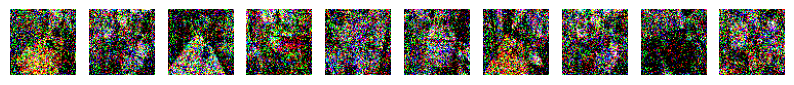

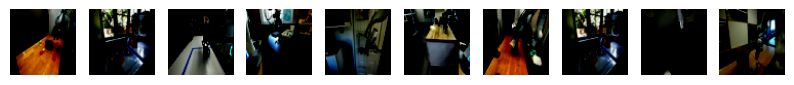

100%|██████████| 391/391 [00:12<00:00, 30.47it/s]


Epoch 2, Avg Training Loss: 0.976032


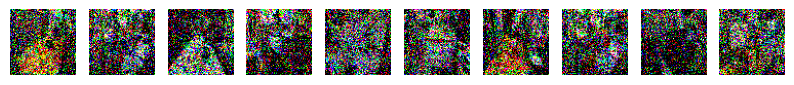

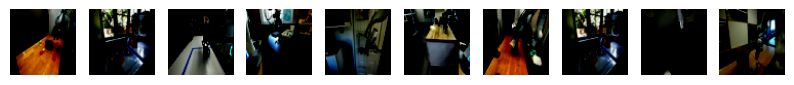

100%|██████████| 391/391 [00:12<00:00, 32.40it/s]


Epoch 3, Avg Training Loss: 0.848634


100%|██████████| 391/391 [00:11<00:00, 32.97it/s]


Epoch 4, Avg Training Loss: 0.732134


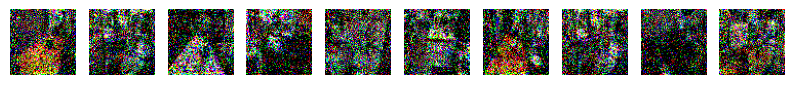

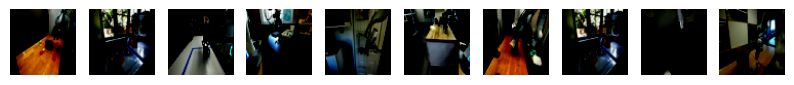

100%|██████████| 391/391 [00:11<00:00, 32.84it/s]


Epoch 5, Avg Training Loss: 0.649714


100%|██████████| 391/391 [00:11<00:00, 32.71it/s]


Epoch 6, Avg Training Loss: 0.565149


100%|██████████| 391/391 [00:11<00:00, 32.68it/s]


Epoch 7, Avg Training Loss: 0.489275


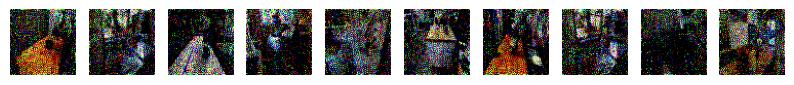

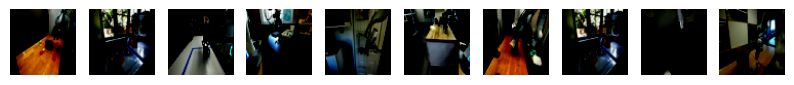

100%|██████████| 391/391 [00:12<00:00, 32.50it/s]


Epoch 8, Avg Training Loss: 0.444922


100%|██████████| 391/391 [00:11<00:00, 32.85it/s]


Epoch 9, Avg Training Loss: 0.419750


100%|██████████| 391/391 [00:11<00:00, 32.82it/s]


Epoch 10, Avg Training Loss: 0.399813


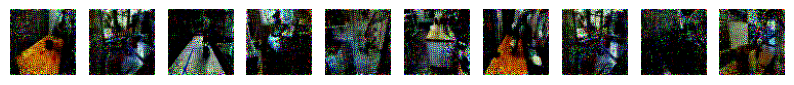

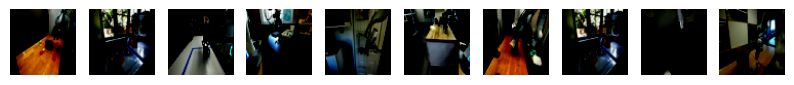

100%|██████████| 391/391 [00:11<00:00, 32.83it/s]


Epoch 11, Avg Training Loss: 0.382033


100%|██████████| 391/391 [00:11<00:00, 32.92it/s]


Epoch 12, Avg Training Loss: 0.365723


100%|██████████| 391/391 [00:11<00:00, 32.89it/s]


Epoch 13, Avg Training Loss: 0.349001


100%|██████████| 391/391 [00:11<00:00, 32.87it/s]


Epoch 14, Avg Training Loss: 0.344848


100%|██████████| 391/391 [00:11<00:00, 32.92it/s]


Epoch 15, Avg Training Loss: 0.336943


100%|██████████| 391/391 [00:11<00:00, 33.59it/s]


Epoch 16, Avg Training Loss: 0.320954


100%|██████████| 391/391 [00:11<00:00, 34.11it/s]


Epoch 17, Avg Training Loss: 0.313879


100%|██████████| 391/391 [00:11<00:00, 32.72it/s]


Epoch 18, Avg Training Loss: 0.311074


100%|██████████| 391/391 [00:12<00:00, 32.43it/s]


Epoch 19, Avg Training Loss: 0.306554


100%|██████████| 391/391 [00:11<00:00, 32.92it/s]


Epoch 20, Avg Training Loss: 0.296001


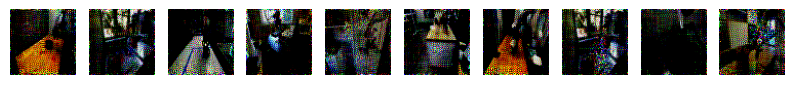

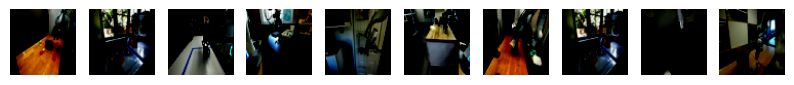

100%|██████████| 391/391 [00:11<00:00, 33.01it/s]


Epoch 21, Avg Training Loss: 0.291207


100%|██████████| 391/391 [00:11<00:00, 33.09it/s]


Epoch 22, Avg Training Loss: 0.284383


100%|██████████| 391/391 [00:11<00:00, 33.04it/s]


Epoch 23, Avg Training Loss: 0.287557


100%|██████████| 391/391 [00:11<00:00, 32.93it/s]


Epoch 24, Avg Training Loss: 0.278698


100%|██████████| 391/391 [00:12<00:00, 32.47it/s]


Epoch 25, Avg Training Loss: 0.274707


100%|██████████| 391/391 [00:12<00:00, 32.27it/s]


Epoch 26, Avg Training Loss: 0.270059


100%|██████████| 391/391 [00:11<00:00, 34.24it/s]


Epoch 27, Avg Training Loss: 0.261957


100%|██████████| 391/391 [00:11<00:00, 34.41it/s]


Epoch 28, Avg Training Loss: 0.263237


100%|██████████| 391/391 [00:12<00:00, 31.91it/s]


Epoch 29, Avg Training Loss: 0.258656


100%|██████████| 391/391 [00:12<00:00, 32.26it/s]


Epoch 30, Avg Training Loss: 0.253346


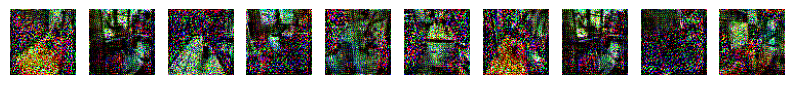

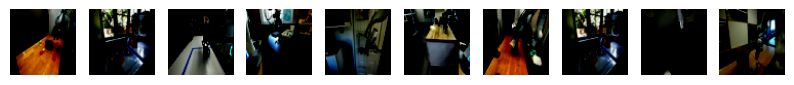

100%|██████████| 391/391 [00:12<00:00, 32.39it/s]


Epoch 31, Avg Training Loss: 0.258338


100%|██████████| 391/391 [00:12<00:00, 32.37it/s]


Epoch 32, Avg Training Loss: 0.245756


100%|██████████| 391/391 [00:12<00:00, 32.33it/s]


Epoch 33, Avg Training Loss: 0.245101


100%|██████████| 391/391 [00:11<00:00, 33.18it/s]


Epoch 34, Avg Training Loss: 0.239631


100%|██████████| 391/391 [00:11<00:00, 33.16it/s]


Epoch 35, Avg Training Loss: 0.236739


100%|██████████| 391/391 [00:11<00:00, 32.90it/s]


Epoch 36, Avg Training Loss: 0.232896


100%|██████████| 391/391 [00:11<00:00, 32.73it/s]


Epoch 37, Avg Training Loss: 0.231222


100%|██████████| 391/391 [00:11<00:00, 32.91it/s]


Epoch 38, Avg Training Loss: 0.229915


100%|██████████| 391/391 [00:11<00:00, 32.74it/s]


Epoch 39, Avg Training Loss: 0.231303


100%|██████████| 391/391 [00:11<00:00, 35.22it/s]


Epoch 40, Avg Training Loss: 0.228420


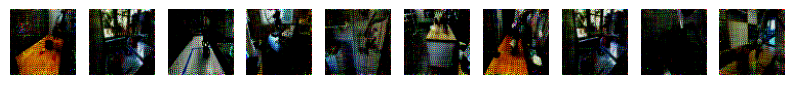

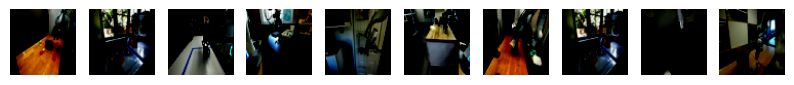

100%|██████████| 391/391 [00:10<00:00, 35.68it/s]


Epoch 41, Avg Training Loss: 0.224963


100%|██████████| 391/391 [00:11<00:00, 35.35it/s]


Epoch 42, Avg Training Loss: 0.223277


100%|██████████| 391/391 [00:11<00:00, 33.36it/s]


Epoch 43, Avg Training Loss: 0.219768


100%|██████████| 391/391 [00:10<00:00, 36.90it/s]


Epoch 44, Avg Training Loss: 0.235544


100%|██████████| 391/391 [00:11<00:00, 34.25it/s]


Epoch 45, Avg Training Loss: 0.223742


100%|██████████| 391/391 [00:12<00:00, 31.86it/s]


Epoch 46, Avg Training Loss: 0.221217


100%|██████████| 391/391 [00:12<00:00, 32.57it/s]


Epoch 47, Avg Training Loss: 0.219840


100%|██████████| 391/391 [00:11<00:00, 34.72it/s]


Epoch 48, Avg Training Loss: 0.217340


100%|██████████| 391/391 [00:11<00:00, 34.89it/s]


Epoch 49, Avg Training Loss: 0.217813


100%|██████████| 391/391 [00:11<00:00, 34.83it/s]


Epoch 50, Avg Training Loss: 0.212282


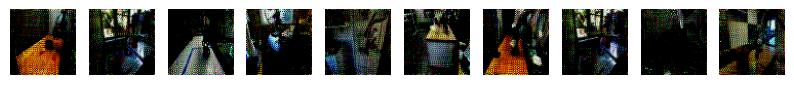

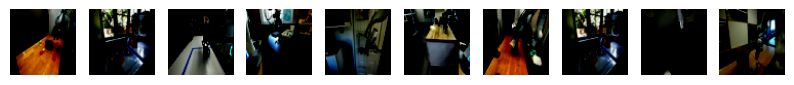

In [ ]:
device = "cuda"

# Hyperparameters
D = 256
learning_rate = 1e-4
num_epochs = 50
test_epochs = [1, 2, 4, 7, 10, 20, 30, 40, 50]
batch_size = 64
K = 10
N = 1   # number of cascaded models
sample_rate = 0   # probability of sampling gt

# Load dataset and split
dataset = DroidDataset(
    data_path=cfg.data.data_dir,
    dataset_name=cfg.data.dataset_name,
    camera=cfg.data.camera,
    horizon=K+N,
    img_size=(64, 64),
)
# dataset = DroidDataset(k=K+N, frame_size=(64, 64), dir="drive/MyDrive/CS280/droid_small", video_source="observation.images.exterior_1_left")
print(len(dataset))
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define model
models = [
    FlowMatching(WorldModelUNet(
        action_dim=7,
        k=K,
        D=D
    )).to(device)
    for _ in range(N)
]

# models = [
#     FlowMatching(WorldModelUNet(
#         in_channels=3,
#         action_dim=7,
#         k=K,
#         num_hiddens=D,
#     )).to(device)
#     for _ in range(N)
# ]

# Optimizer and scheduler
optimizers = [
    torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    for model in models
]
schedulers = [
    torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)
    for opt in optimizers
]

training_losses = []
test_data = []
avg_train_losses = []
try:
    for epoch in range(num_epochs):
        # for model in models:
        #     freeze_pretrained_encoder_until(model.unet, epoch, 5)  # Unfreeze after epoch 5
        for model in models:
            model.train()
        avg_train_loss = 0

        # anneal sample rate
        # sample_rate = max(0.5, 1.0 - epoch / num_epochs)
        for sample_dict in tqdm(trainloader):
        #for frames_cond, actions_cond, _, _ in tqdm(trainloader):
            frames_cond = sample_dict["context_obs"]
            actions_cond = sample_dict["context_acts"]
            # print(frames_cond.shape, actions_cond.shape)
            frames_cond = frames_cond.to(device)     # (B, k, 3, H, W)
            actions_cond = actions_cond.to(device)   # (B, k, action_dim)

            for opt in optimizers:
                opt.zero_grad()
            # loss = 0
            B = frames_cond.size(0)
            pred_frames = frames_cond[:, :K].clone()

            for i, model in enumerate(models):
                frames_cond_i = frames_cond[:, i:i+K]   # (B, k, 3, H, W)
                frames_cond_pred_i = pred_frames        # (B, k, 3, H, W)
                # print(frames_cond_i.shape, frames_cond_pred_i.shape)
                mask = (torch.rand(B, K, 1, 1, 1, device=device) < sample_rate).float()
                frames_cond_mix_i = mask * frames_cond_i + (1 - mask) * frames_cond_pred_i

                actions_cond_i = actions_cond[:, i:i+K]

                frame_cur_i = frames_cond_mix_i[:, -1]
                frame_next_i = frames_cond[:, i+K]
                label_i = frame_next_i - frame_cur_i

                # print(frames_cond_mix_i.shape, actions_cond_i.shape, label_i.shape)
                loss_i, pred_i = model(label_i, frames_cond_mix_i, actions_cond_i)

                pred_next_frame = frame_cur_i + pred_i.detach()
                pred_frames = torch.cat([pred_frames[:, 1:], pred_next_frame.unsqueeze(1)], dim=1)

                loss_i.backward()
                optimizers[i].step()

            for scheduler in schedulers:
                scheduler.step()

            avg_train_loss += loss_i.item() / len(trainloader)
            training_losses.append(loss_i.item())

        # scheduler.step()
        print(f"Epoch {epoch + 1}, Avg Training Loss: {avg_train_loss:.6f}")
        avg_train_losses.append(avg_train_loss)
        # testing (sampling)
        if (epoch + 1) in test_epochs:
            for model in models:
                model.eval()
            batch = next(iter(testloader))
            frames_cond = batch["context_obs"]
            actions_cond = batch["context_acts"]
            ground_truth = batch["obs"]
            # frames_cond, actions_cond, _, ground_truth = batch

            frames_cond = frames_cond.to(device)
            actions_cond = actions_cond.to(device)

            # Only take the most recent frame (the latest in frames_cond sequence)
            current_frame = frames_cond[:, -1]  # (N, 3, H, W)

            # Sample the predicted difference
            # predicted_diff = models[-1].sample(
            #     frames_cond[:10],
            #     actions_cond[:10],
            #     img_wh=(frames_cond.shape[-2], frames_cond.shape[-1]),
            #     guidance_scale=5.0,
            #     N=10,  # should match frames_cond[:10]
            # ).cpu()
            
            predicted_diff = models[-1].sample(
                frames_cond[:10, :K],
                actions_cond[:10, :K],
                img_wh=(frames_cond.shape[-2], frames_cond.shape[-1]),
                guidance_scale=5.0,
                N=10,  # should match frames_cond[:10]
            ).cpu()
            # Compute predicted next frames
            predicted_next_frame = current_frame[:10].cpu() + predicted_diff  # add predicted delta

            # Display first few predicted next frames
            displayImageRow(predicted_next_frame.permute(0, 2, 3, 1), figsize=(10,10))
            displayImageRow(ground_truth[:10].permute(0, 2, 3, 1), figsize=(10,10))

            # test_data.append(predicted_next_frame.numpy())

finally:
    pass
#     dataset.close()

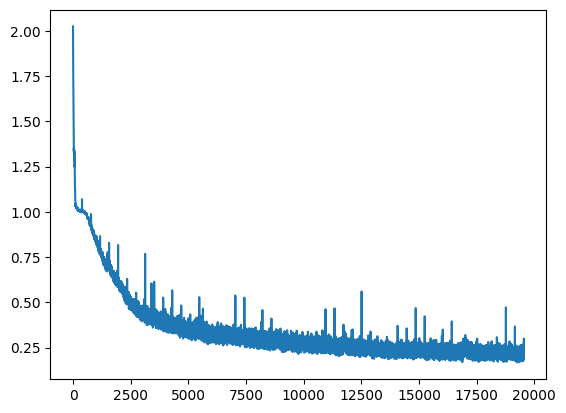

In [14]:
plt.plot(training_losses)

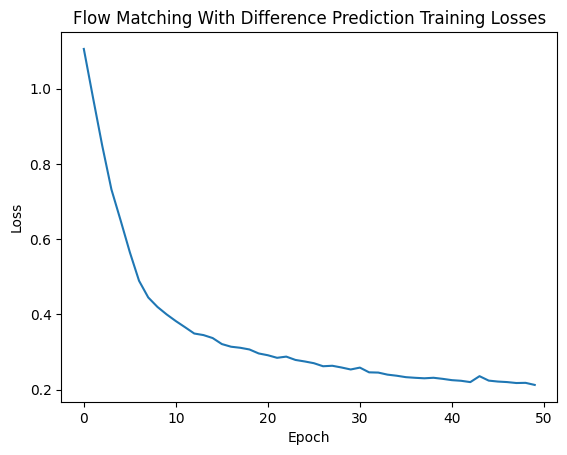

In [16]:
plt.title("Flow Matching With Difference Prediction Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(avg_train_losses)

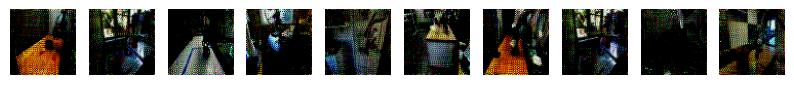

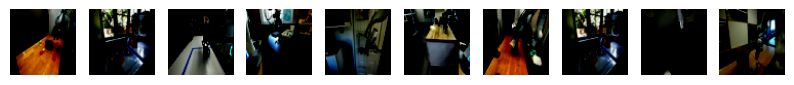

In [17]:
dataset = DroidDataset(
    data_path=cfg.data.data_dir,
    dataset_name=cfg.data.dataset_name,
    camera=cfg.data.camera,
    horizon=K+N,
    img_size=(64, 64),
)
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

try:

    for model in models:
        model.eval()
    batch = next(iter(testloader))
    # frames_cond, actions_cond, _, ground_truth = batch
    frames_cond = batch["context_obs"]
    actions_cond = batch["context_acts"]
    ground_truth = batch["obs"]
    frames_cond = frames_cond.to(device)
    actions_cond = actions_cond.to(device)

    # Only take the most recent frame (the latest in frames_cond sequence)
    current_frame = frames_cond[:, K]  # (N, 3, H, W)

    # Sample the predicted difference
    predicted_diff = models[-1].sample(
        frames_cond[:10, :K],
        actions_cond[:10, :K],
        img_wh=(frames_cond.shape[-2], frames_cond.shape[-1]),
        guidance_scale=5.0,
        N=10,  # should match frames_cond[:10]
    ).cpu()

    # Compute predicted next frames
    predicted_next_frame = current_frame[:10, :K].cpu() + predicted_diff  # add predicted delta

    # Display first few predicted next frames
    displayImageRow(predicted_next_frame.permute(0, 2, 3, 1), figsize=(10,10))
    displayImageRow(ground_truth[:10].permute(0, 2, 3, 1), figsize=(10,10))

finally:
    pass

In [18]:
filename = 'output_flow_matching_difference/'

[DroidDataset] Building memmaps from TFDS…


2025-05-11 20:10:00.447988: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[DroidDataset] Wrote shard 0 with 27348 samples.


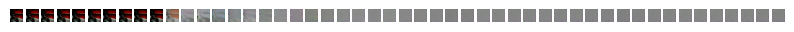

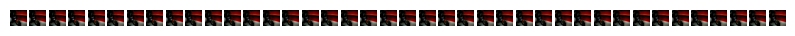

In [19]:
test_dataset = DroidDataset(
    data_path=cfg.data.data_dir,
    dataset_name=cfg.data.dataset_name,
    camera=cfg.data.camera,
    horizon=50,
    img_size=(64, 64),
)

try:
    batch = test_dataset[150]
    frames = batch["context_obs"]
    actions = batch["context_acts"]

    # frames, actions, _, _ = test_dataset[150]
    frames_cond = frames[:K]
    # frames_cond = frames

    pred_frames = frames_cond.clone().to(device)
    actions = actions.to(device)
    
    # print(pred_frames.shape, actions.shape)
    for i in range(K, 50):
        pred_diff = models[-1].sample(
            pred_frames[-K:].unsqueeze(0),
            actions[i-K:i].unsqueeze(0),                           # Corresponding K actions
            img_wh=(frames.shape[-2], frames.shape[-1]),
            guidance_scale=5.0,
            N=1,
        )
        #     actions[i-K:i].unsqueeze(0),                 # corresponding K actions
        #     img_wh=(frames.shape[-2], frames.shape[-1]),
        #     guidance_scale=5.0,
        #     N=1,
        # )
        # print(pred_diff.shape)
        # print(pred_frames[-1].shape)
        pred = pred_frames[-1] + pred_diff
        pred = normalize(pred)
        # print(pred.shape)
        # print(pred_frames.shape)
        pred_frames = torch.cat([pred_frames, pred], dim=0)  # append prediction

finally:
    pass
    # test_dataset.close()

displayImageRow(pred_frames.cpu().permute(0, 2, 3, 1), figsize=(10,10))
displayImageRow(frames[K:].permute(0, 2, 3, 1), figsize=(10,10))
save_frames_as_gif(pred_frames, filename+"predicted_1.gif")
save_frames_as_gif(frames, filename+"ground_truth_1.gif")


{'obs': tensor([[[ 0.6784,  0.6863,  0.4353,  ..., -0.7804, -0.7020, -0.5216],
         [ 0.6863,  0.6863,  0.5686,  ..., -0.8039, -0.6314, -0.6000],
         [ 0.6784,  0.6784,  0.6471,  ..., -0.5843, -0.4353, -0.4275],
         ...,
         [-0.7725, -0.2549, -0.0353,  ...,  0.6392,  0.6392,  0.6235],
         [-0.4039, -0.0667,  0.0118,  ...,  0.6235,  0.6157,  0.5922],
         [-0.1765, -0.0196, -0.0510,  ...,  0.6000,  0.5922,  0.5608]],

        [[ 0.8275,  0.8588,  0.5608,  ..., -0.7647, -0.7020, -0.5137],
         [ 0.8275,  0.8510,  0.7020,  ..., -0.7804, -0.6078, -0.5686],
         [ 0.8196,  0.8353,  0.7882,  ..., -0.5608, -0.4039, -0.3961],
         ...,
         [-0.6863, -0.1216,  0.1373,  ...,  0.5765,  0.5765,  0.5686],
         [-0.2784,  0.0980,  0.1765,  ...,  0.5686,  0.5686,  0.5529],
         [-0.0196,  0.1373,  0.1137,  ...,  0.5686,  0.5608,  0.5373]],

        [[ 0.9451,  0.9373,  0.6235,  ..., -0.6706, -0.5922, -0.4353],
         [ 0.9451,  0.9451,  0.7725, 

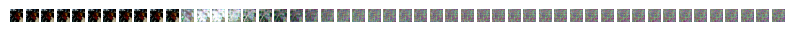

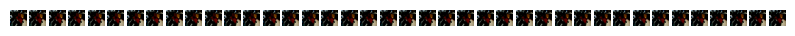

{'obs': tensor([[[ 0.6784,  0.6941,  0.4510,  ..., -0.7882, -0.7333, -0.5137],
         [ 0.6784,  0.6863,  0.5765,  ..., -0.7961, -0.6471, -0.5686],
         [ 0.6706,  0.6706,  0.6549,  ..., -0.5608, -0.4275, -0.4039],
         ...,
         [-0.7569, -0.2471, -0.0353,  ...,  0.6314,  0.6314,  0.6157],
         [-0.3882, -0.0588,  0.0118,  ...,  0.6157,  0.6078,  0.5922],
         [-0.1843, -0.0275, -0.0510,  ...,  0.6000,  0.5922,  0.5608]],

        [[ 0.8275,  0.8510,  0.5686,  ..., -0.7647, -0.7098, -0.4902],
         [ 0.8353,  0.8510,  0.7098,  ..., -0.7725, -0.6157, -0.5529],
         [ 0.8196,  0.8353,  0.7961,  ..., -0.5451, -0.4039, -0.3882],
         ...,
         [-0.6784, -0.1137,  0.1216,  ...,  0.5843,  0.5843,  0.5686],
         [-0.2706,  0.0980,  0.1686,  ...,  0.5765,  0.5686,  0.5608],
         [-0.0275,  0.1373,  0.0980,  ...,  0.5686,  0.5608,  0.5373]],

        [[ 0.9451,  0.9373,  0.6314,  ..., -0.6706, -0.6235, -0.4196],
         [ 0.9451,  0.9294,  0.7804, 

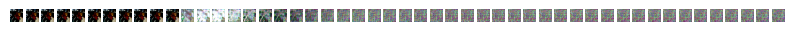

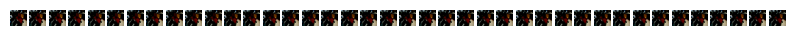

{'obs': tensor([[[ 0.6863,  0.6941,  0.4588,  ..., -0.7804, -0.7333, -0.5137],
         [ 0.6784,  0.6863,  0.5843,  ..., -0.7961, -0.6471, -0.5686],
         [ 0.6784,  0.6784,  0.6549,  ..., -0.5529, -0.4275, -0.4039],
         ...,
         [-0.7647, -0.2706, -0.0588,  ...,  0.6235,  0.6314,  0.6157],
         [-0.3961, -0.0824, -0.0118,  ...,  0.6078,  0.6078,  0.5922],
         [-0.1843, -0.0431, -0.0745,  ...,  0.6000,  0.5843,  0.5608]],

        [[ 0.8353,  0.8510,  0.5765,  ..., -0.7647, -0.7098, -0.4902],
         [ 0.8275,  0.8510,  0.7176,  ..., -0.7804, -0.6157, -0.5451],
         [ 0.8196,  0.8353,  0.8039,  ..., -0.5451, -0.4039, -0.3882],
         ...,
         [-0.6941, -0.1373,  0.0980,  ...,  0.5765,  0.5843,  0.5686],
         [-0.2941,  0.0745,  0.1451,  ...,  0.5686,  0.5686,  0.5529],
         [-0.0275,  0.1216,  0.0902,  ...,  0.5686,  0.5529,  0.5294]],

        [[ 0.9373,  0.9294,  0.6471,  ..., -0.6784, -0.6235, -0.4118],
         [ 0.9373,  0.9294,  0.7804, 

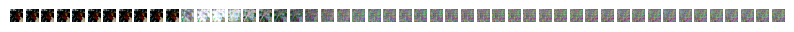

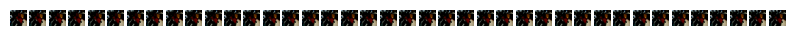

{'obs': tensor([[[ 0.6863,  0.7098,  0.4510,  ..., -0.7725, -0.7255, -0.5137],
         [ 0.6863,  0.7020,  0.5765,  ..., -0.7961, -0.6392, -0.5765],
         [ 0.6784,  0.6784,  0.6627,  ..., -0.5765, -0.4353, -0.4196],
         ...,
         [-0.7725, -0.2627, -0.0588,  ...,  0.6235,  0.6314,  0.6157],
         [-0.3961, -0.0745, -0.0118,  ...,  0.6157,  0.6157,  0.6000],
         [-0.1686, -0.0353, -0.0667,  ...,  0.6078,  0.5922,  0.5765]],

        [[ 0.8275,  0.8510,  0.5765,  ..., -0.7647, -0.7020, -0.4980],
         [ 0.8275,  0.8510,  0.7098,  ..., -0.7725, -0.6078, -0.5451],
         [ 0.8275,  0.8353,  0.7961,  ..., -0.5686, -0.4118, -0.4039],
         ...,
         [-0.6863, -0.1216,  0.1059,  ...,  0.5765,  0.5843,  0.5686],
         [-0.2863,  0.0902,  0.1451,  ...,  0.5765,  0.5686,  0.5608],
         [-0.0353,  0.1216,  0.0902,  ...,  0.5686,  0.5608,  0.5373]],

        [[ 0.9373,  0.9373,  0.6392,  ..., -0.6784, -0.6157, -0.4196],
         [ 0.9451,  0.9451,  0.7804, 

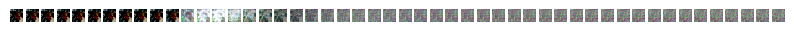

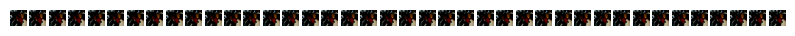

{'obs': tensor([[[ 0.6863,  0.7020,  0.4510,  ..., -0.7725, -0.7333, -0.5059],
         [ 0.6784,  0.6941,  0.5765,  ..., -0.7961, -0.6549, -0.5686],
         [ 0.6706,  0.6863,  0.6627,  ..., -0.5686, -0.4431, -0.4118],
         ...,
         [-0.7647, -0.2627, -0.0588,  ...,  0.6314,  0.6314,  0.6157],
         [-0.3961, -0.0824, -0.0039,  ...,  0.6078,  0.6078,  0.6078],
         [-0.1765, -0.0353, -0.0667,  ...,  0.5843,  0.5843,  0.5765]],

        [[ 0.8275,  0.8588,  0.5843,  ..., -0.7569, -0.7098, -0.4902],
         [ 0.8275,  0.8510,  0.7176,  ..., -0.7804, -0.6235, -0.5451],
         [ 0.8196,  0.8353,  0.8039,  ..., -0.5686, -0.4118, -0.3961],
         ...,
         [-0.6863, -0.1216,  0.1137,  ...,  0.5843,  0.5843,  0.5608],
         [-0.2784,  0.0902,  0.1529,  ...,  0.5843,  0.5765,  0.5608],
         [-0.0353,  0.1294,  0.0824,  ...,  0.5686,  0.5608,  0.5373]],

        [[ 0.9451,  0.9451,  0.6471,  ..., -0.6706, -0.6314, -0.4275],
         [ 0.9373,  0.9451,  0.7882, 

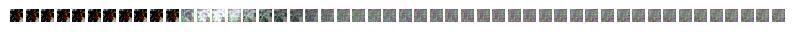

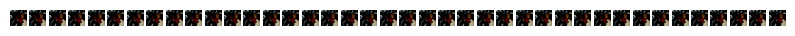

{'obs': tensor([[[ 0.6784,  0.6941,  0.4510,  ..., -0.7804, -0.7255, -0.4980],
         [ 0.6706,  0.6863,  0.5843,  ..., -0.8039, -0.6471, -0.5765],
         [ 0.6706,  0.6863,  0.6627,  ..., -0.5765, -0.4431, -0.4118],
         ...,
         [-0.7647, -0.2549, -0.0510,  ...,  0.6314,  0.6314,  0.6157],
         [-0.3961, -0.0745, -0.0039,  ...,  0.6157,  0.6078,  0.5922],
         [-0.1686, -0.0353, -0.0667,  ...,  0.6000,  0.5922,  0.5529]],

        [[ 0.8275,  0.8588,  0.5765,  ..., -0.7569, -0.7098, -0.4902],
         [ 0.8275,  0.8510,  0.7255,  ..., -0.7647, -0.6157, -0.5451],
         [ 0.8196,  0.8353,  0.8039,  ..., -0.5529, -0.4118, -0.3882],
         ...,
         [-0.6784, -0.1216,  0.1137,  ...,  0.5843,  0.5843,  0.5686],
         [-0.2706,  0.0902,  0.1529,  ...,  0.5686,  0.5686,  0.5608],
         [-0.0196,  0.1294,  0.0824,  ...,  0.5686,  0.5529,  0.5373]],

        [[ 0.9294,  0.9294,  0.6392,  ..., -0.6863, -0.6235, -0.4196],
         [ 0.9373,  0.9294,  0.7882, 

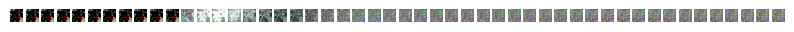

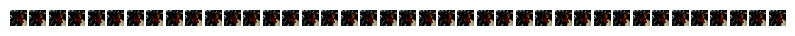

{'obs': tensor([[[ 0.6784,  0.6941,  0.4510,  ..., -0.7804, -0.7255, -0.5216],
         [ 0.6784,  0.6863,  0.5843,  ..., -0.8039, -0.6549, -0.5843],
         [ 0.6784,  0.6784,  0.6549,  ..., -0.5765, -0.4431, -0.4196],
         ...,
         [-0.7647, -0.2471, -0.0353,  ...,  0.6235,  0.6314,  0.6157],
         [-0.4039, -0.0588,  0.0039,  ...,  0.6157,  0.6157,  0.5922],
         [-0.1765, -0.0275, -0.0588,  ...,  0.6000,  0.5922,  0.5608]],

        [[ 0.8275,  0.8588,  0.5843,  ..., -0.7569, -0.7098, -0.4902],
         [ 0.8275,  0.8510,  0.7176,  ..., -0.7725, -0.6157, -0.5451],
         [ 0.8275,  0.8353,  0.7961,  ..., -0.5608, -0.4118, -0.3961],
         ...,
         [-0.6784, -0.1216,  0.1216,  ...,  0.5765,  0.5922,  0.5686],
         [-0.2784,  0.0980,  0.1686,  ...,  0.5765,  0.5765,  0.5608],
         [-0.0275,  0.1373,  0.0980,  ...,  0.5686,  0.5608,  0.5451]],

        [[ 0.9294,  0.9373,  0.6471,  ..., -0.6863, -0.6235, -0.4275],
         [ 0.9373,  0.9373,  0.7804, 

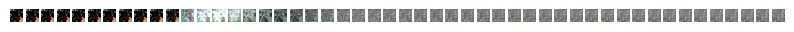

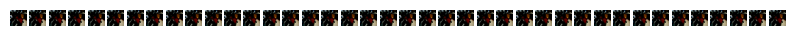

{'obs': tensor([[[ 0.6706,  0.6941,  0.4510,  ..., -0.7725, -0.7255, -0.5216],
         [ 0.6784,  0.6941,  0.5765,  ..., -0.7961, -0.6549, -0.5922],
         [ 0.6706,  0.6784,  0.6549,  ..., -0.5765, -0.4353, -0.4196],
         ...,
         [-0.7725, -0.2627, -0.0431,  ...,  0.6314,  0.6314,  0.6235],
         [-0.4118, -0.0667,  0.0118,  ...,  0.6078,  0.6078,  0.6078],
         [-0.1843, -0.0196, -0.0431,  ...,  0.5922,  0.5843,  0.5686]],

        [[ 0.8353,  0.8588,  0.5765,  ..., -0.7647, -0.7098, -0.4902],
         [ 0.8275,  0.8510,  0.7098,  ..., -0.7725, -0.6157, -0.5529],
         [ 0.8196,  0.8353,  0.7961,  ..., -0.5608, -0.4039, -0.3961],
         ...,
         [-0.6941, -0.1216,  0.1216,  ...,  0.5843,  0.5843,  0.5765],
         [-0.2863,  0.0980,  0.1765,  ...,  0.5765,  0.5765,  0.5686],
         [-0.0353,  0.1529,  0.1137,  ...,  0.5686,  0.5686,  0.5451]],

        [[ 0.9294,  0.9294,  0.6392,  ..., -0.6784, -0.6235, -0.4275],
         [ 0.9294,  0.9294,  0.7725, 

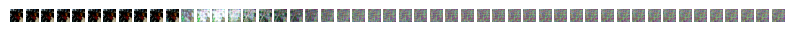

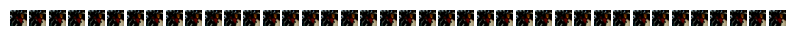

{'obs': tensor([[[ 0.6706,  0.7020,  0.4431,  ..., -0.7725, -0.7176, -0.5137],
         [ 0.6784,  0.6941,  0.5686,  ..., -0.7961, -0.6314, -0.5843],
         [ 0.6706,  0.6863,  0.6549,  ..., -0.5765, -0.4275, -0.4275],
         ...,
         [-0.7725, -0.2549, -0.0431,  ...,  0.6314,  0.6314,  0.6157],
         [-0.4039, -0.0588,  0.0118,  ...,  0.6157,  0.6000,  0.5922],
         [-0.1765, -0.0196, -0.0510,  ...,  0.5922,  0.5765,  0.5608]],

        [[ 0.8353,  0.8588,  0.5686,  ..., -0.7647, -0.6941, -0.5059],
         [ 0.8275,  0.8510,  0.7098,  ..., -0.7725, -0.6000, -0.5608],
         [ 0.8196,  0.8353,  0.7961,  ..., -0.5608, -0.4039, -0.4039],
         ...,
         [-0.6863, -0.1216,  0.1137,  ...,  0.5843,  0.5843,  0.5765],
         [-0.2706,  0.0980,  0.1686,  ...,  0.5843,  0.5765,  0.5608],
         [-0.0275,  0.1529,  0.1059,  ...,  0.5765,  0.5608,  0.5373]],

        [[ 0.9294,  0.9294,  0.6314,  ..., -0.6706, -0.6078, -0.4275],
         [ 0.9373,  0.9294,  0.7725, 

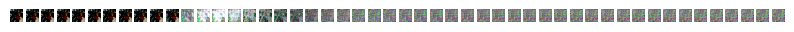

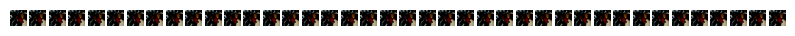

{'obs': tensor([[[ 0.6784,  0.6941,  0.4431,  ..., -0.7725, -0.7176, -0.5294],
         [ 0.6784,  0.6941,  0.5765,  ..., -0.8039, -0.6392, -0.5922],
         [ 0.6784,  0.6863,  0.6627,  ..., -0.5765, -0.4353, -0.4196],
         ...,
         [-0.7647, -0.2549, -0.0510,  ...,  0.6314,  0.6314,  0.6157],
         [-0.4039, -0.0667, -0.0039,  ...,  0.6157,  0.6078,  0.6000],
         [-0.1765, -0.0275, -0.0667,  ...,  0.6000,  0.5843,  0.5608]],

        [[ 0.8353,  0.8667,  0.5765,  ..., -0.7647, -0.7020, -0.4980],
         [ 0.8275,  0.8510,  0.7176,  ..., -0.7725, -0.6078, -0.5608],
         [ 0.8275,  0.8353,  0.8039,  ..., -0.5686, -0.4118, -0.3961],
         ...,
         [-0.6941, -0.1373,  0.1216,  ...,  0.5843,  0.5843,  0.5686],
         [-0.2863,  0.0902,  0.1608,  ...,  0.5765,  0.5765,  0.5608],
         [-0.0275,  0.1451,  0.0980,  ...,  0.5765,  0.5686,  0.5451]],

        [[ 0.9294,  0.9294,  0.6314,  ..., -0.6784, -0.6078, -0.4196],
         [ 0.9294,  0.9294,  0.7804, 

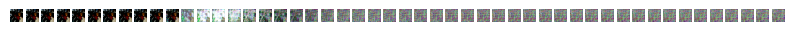

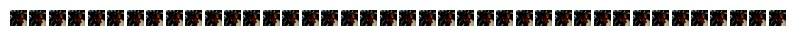

{'obs': tensor([[[ 0.6863,  0.7020,  0.4510,  ..., -0.7882, -0.7255, -0.5216],
         [ 0.6784,  0.6941,  0.5765,  ..., -0.8039, -0.6471, -0.5765],
         [ 0.6784,  0.6863,  0.6549,  ..., -0.5608, -0.4275, -0.4118],
         ...,
         [-0.7725, -0.2706, -0.0510,  ...,  0.6314,  0.6314,  0.6157],
         [-0.4118, -0.0824,  0.0039,  ...,  0.6157,  0.6157,  0.6000],
         [-0.1765, -0.0353, -0.0667,  ...,  0.6000,  0.5843,  0.5608]],

        [[ 0.8275,  0.8510,  0.5765,  ..., -0.7647, -0.7098, -0.4980],
         [ 0.8275,  0.8510,  0.7176,  ..., -0.7725, -0.6157, -0.5451],
         [ 0.8275,  0.8353,  0.8039,  ..., -0.5451, -0.4039, -0.3882],
         ...,
         [-0.6784, -0.1294,  0.1137,  ...,  0.5843,  0.5843,  0.5686],
         [-0.2784,  0.0902,  0.1608,  ...,  0.5843,  0.5765,  0.5608],
         [-0.0275,  0.1373,  0.0980,  ...,  0.5765,  0.5608,  0.5373]],

        [[ 0.9451,  0.9373,  0.6392,  ..., -0.6784, -0.6000, -0.4039],
         [ 0.9373,  0.9373,  0.7804, 

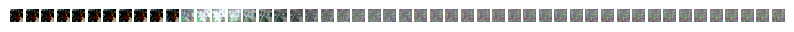

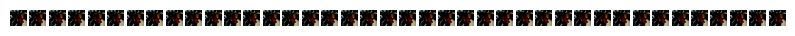

{'obs': tensor([[[ 0.6863,  0.7020,  0.4588,  ..., -0.7804, -0.7333, -0.5137],
         [ 0.6863,  0.6941,  0.5843,  ..., -0.8039, -0.6549, -0.5686],
         [ 0.6784,  0.6784,  0.6627,  ..., -0.5608, -0.4275, -0.4039],
         ...,
         [-0.7725, -0.2627, -0.0588,  ...,  0.6235,  0.6314,  0.6157],
         [-0.4118, -0.0745, -0.0039,  ...,  0.6157,  0.6157,  0.6000],
         [-0.1765, -0.0353, -0.0745,  ...,  0.6000,  0.5922,  0.5686]],

        [[ 0.8275,  0.8588,  0.5843,  ..., -0.7647, -0.7176, -0.4902],
         [ 0.8275,  0.8510,  0.7255,  ..., -0.7725, -0.6235, -0.5373],
         [ 0.8196,  0.8353,  0.8118,  ..., -0.5451, -0.4039, -0.3804],
         ...,
         [-0.6863, -0.1373,  0.1137,  ...,  0.5843,  0.5843,  0.5686],
         [-0.2863,  0.0824,  0.1529,  ...,  0.5843,  0.5765,  0.5608],
         [-0.0275,  0.1373,  0.0902,  ...,  0.5843,  0.5686,  0.5451]],

        [[ 0.9451,  0.9451,  0.6471,  ..., -0.6784, -0.6314, -0.4039],
         [ 0.9373,  0.9373,  0.7882, 

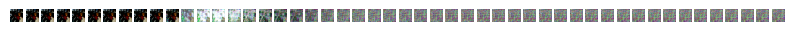

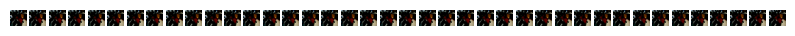

{'obs': tensor([[[ 0.6863,  0.6941,  0.4510,  ..., -0.7725, -0.7176, -0.5059],
         [ 0.6784,  0.6863,  0.5843,  ..., -0.7961, -0.6392, -0.5765],
         [ 0.6706,  0.6863,  0.6627,  ..., -0.5686, -0.4196, -0.4118],
         ...,
         [-0.7804, -0.2784, -0.0667,  ...,  0.6157,  0.6235,  0.6157],
         [-0.4118, -0.0667, -0.0118,  ...,  0.6078,  0.6078,  0.5922],
         [-0.1765, -0.0196, -0.0745,  ...,  0.5922,  0.5843,  0.5608]],

        [[ 0.8275,  0.8510,  0.5765,  ..., -0.7647, -0.7098, -0.4980],
         [ 0.8275,  0.8510,  0.7098,  ..., -0.7725, -0.6078, -0.5451],
         [ 0.8196,  0.8353,  0.7961,  ..., -0.5529, -0.4039, -0.3882],
         ...,
         [-0.6941, -0.1451,  0.0980,  ...,  0.5843,  0.5765,  0.5686],
         [-0.2941,  0.0824,  0.1451,  ...,  0.5843,  0.5765,  0.5608],
         [-0.0353,  0.1451,  0.0824,  ...,  0.5765,  0.5608,  0.5451]],

        [[ 0.9373,  0.9373,  0.6392,  ..., -0.6784, -0.6235, -0.4196],
         [ 0.9373,  0.9373,  0.7804, 

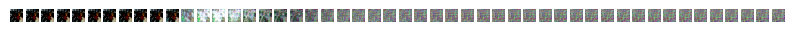

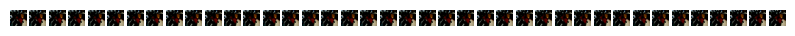

{'obs': tensor([[[ 0.6784,  0.6941,  0.4431,  ..., -0.7725, -0.7255, -0.5137],
         [ 0.6784,  0.6863,  0.5843,  ..., -0.7961, -0.6471, -0.5765],
         [ 0.6706,  0.6863,  0.6627,  ..., -0.5608, -0.4275, -0.4118],
         ...,
         [-0.7725, -0.2863, -0.0745,  ...,  0.6235,  0.6314,  0.6157],
         [-0.4275, -0.0824, -0.0118,  ...,  0.6078,  0.6078,  0.6000],
         [-0.1843, -0.0275, -0.0667,  ...,  0.5922,  0.5922,  0.5608]],

        [[ 0.8275,  0.8510,  0.5686,  ..., -0.7647, -0.7176, -0.4980],
         [ 0.8275,  0.8510,  0.7098,  ..., -0.7725, -0.6235, -0.5529],
         [ 0.8275,  0.8431,  0.7961,  ..., -0.5529, -0.4039, -0.3882],
         ...,
         [-0.7020, -0.1529,  0.0980,  ...,  0.5843,  0.5843,  0.5686],
         [-0.3098,  0.0745,  0.1451,  ...,  0.5843,  0.5686,  0.5608],
         [-0.0431,  0.1294,  0.0824,  ...,  0.5765,  0.5608,  0.5451]],

        [[ 0.9451,  0.9373,  0.6314,  ..., -0.6784, -0.6157, -0.4118],
         [ 0.9451,  0.9373,  0.7804, 

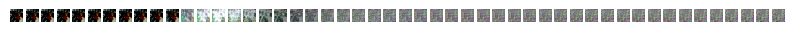

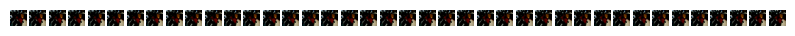

{'obs': tensor([[[ 0.6784,  0.7020,  0.4510,  ..., -0.7725, -0.7176, -0.4980],
         [ 0.6784,  0.6941,  0.5765,  ..., -0.7961, -0.6392, -0.5686],
         [ 0.6706,  0.6863,  0.6627,  ..., -0.5686, -0.4275, -0.4118],
         ...,
         [-0.7804, -0.2941, -0.0745,  ...,  0.6157,  0.6157,  0.6000],
         [-0.4353, -0.0902, -0.0196,  ...,  0.6078,  0.6000,  0.5843],
         [-0.1843, -0.0353, -0.0745,  ...,  0.5922,  0.5843,  0.5529]],

        [[ 0.8275,  0.8510,  0.5765,  ..., -0.7569, -0.7098, -0.4902],
         [ 0.8353,  0.8510,  0.7176,  ..., -0.7725, -0.6157, -0.5373],
         [ 0.8275,  0.8353,  0.8039,  ..., -0.5529, -0.4039, -0.3882],
         ...,
         [-0.7020, -0.1608,  0.0902,  ...,  0.5843,  0.5843,  0.5686],
         [-0.3176,  0.0588,  0.1373,  ...,  0.5765,  0.5765,  0.5608],
         [-0.0510,  0.1216,  0.0824,  ...,  0.5765,  0.5608,  0.5373]],

        [[ 0.9373,  0.9373,  0.6392,  ..., -0.6863, -0.6235, -0.4275],
         [ 0.9373,  0.9373,  0.7804, 

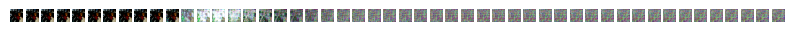

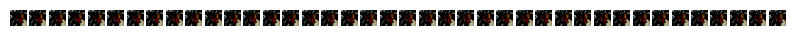

{'obs': tensor([[[ 0.6784,  0.7020,  0.4510,  ..., -0.7725, -0.7098, -0.4980],
         [ 0.6784,  0.7020,  0.5843,  ..., -0.8039, -0.6392, -0.5765],
         [ 0.6784,  0.6863,  0.6549,  ..., -0.5765, -0.4353, -0.4196],
         ...,
         [-0.7725, -0.2784, -0.0667,  ...,  0.6157,  0.6235,  0.6157],
         [-0.4118, -0.0824, -0.0196,  ...,  0.6000,  0.6078,  0.6000],
         [-0.1765, -0.0275, -0.0824,  ...,  0.6000,  0.6000,  0.5608]],

        [[ 0.8353,  0.8510,  0.5765,  ..., -0.7569, -0.7020, -0.4902],
         [ 0.8275,  0.8431,  0.7176,  ..., -0.7725, -0.6157, -0.5451],
         [ 0.8275,  0.8353,  0.8039,  ..., -0.5608, -0.4118, -0.3961],
         ...,
         [-0.6941, -0.1686,  0.0824,  ...,  0.5922,  0.5843,  0.5686],
         [-0.3176,  0.0510,  0.1373,  ...,  0.5765,  0.5765,  0.5608],
         [-0.0588,  0.1137,  0.0745,  ...,  0.5686,  0.5608,  0.5373]],

        [[ 0.9373,  0.9529,  0.6471,  ..., -0.6706, -0.6157, -0.4353],
         [ 0.9373,  0.9451,  0.7882, 

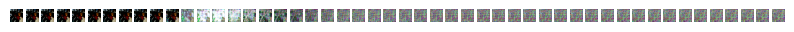

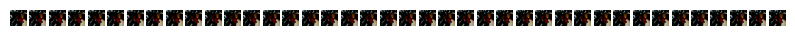

{'obs': tensor([[[ 0.6863,  0.7020,  0.4510,  ..., -0.7725, -0.7098, -0.5059],
         [ 0.6863,  0.6941,  0.5843,  ..., -0.7961, -0.6392, -0.5765],
         [ 0.6863,  0.6863,  0.6549,  ..., -0.5765, -0.4353, -0.4196],
         ...,
         [-0.7804, -0.2863, -0.0745,  ...,  0.6157,  0.6235,  0.6157],
         [-0.4275, -0.0902, -0.0275,  ...,  0.6000,  0.6078,  0.6000],
         [-0.1843, -0.0510, -0.0902,  ...,  0.6078,  0.6000,  0.5608]],

        [[ 0.8353,  0.8431,  0.5686,  ..., -0.7569, -0.7098, -0.5059],
         [ 0.8353,  0.8431,  0.7098,  ..., -0.7725, -0.6157, -0.5529],
         [ 0.8275,  0.8353,  0.7961,  ..., -0.5529, -0.4039, -0.3882],
         ...,
         [-0.6941, -0.1765,  0.0745,  ...,  0.5922,  0.5843,  0.5686],
         [-0.3255,  0.0431,  0.1294,  ...,  0.5843,  0.5686,  0.5608],
         [-0.0588,  0.1059,  0.0667,  ...,  0.5765,  0.5608,  0.5373]],

        [[ 0.9451,  0.9529,  0.6471,  ..., -0.6784, -0.6157, -0.4275],
         [ 0.9451,  0.9529,  0.7961, 

KeyboardInterrupt: 

In [20]:
test_dataset = DroidDataset(
    data_path=cfg.data.data_dir,
    dataset_name=cfg.data.dataset_name,
    camera=cfg.data.camera,
    horizon=50,
    img_size=(64, 64),
)
for idx in range(0, len(test_dataset), 5):
    try:
        
        batch = test_dataset[idx]
        frames = batch["context_obs"]
        actions = batch["context_acts"]
        print(batch)

        # frames, actions, _, _ = test_dataset[150]
        frames_cond = frames[:K]
        # frames_cond = frames

        pred_frames = frames_cond.clone().to(device)
        actions = actions.to(device)
        
        # print(pred_frames.shape, actions.shape)
        for i in range(K, 50):
            pred_diff = models[-1].sample(
                pred_frames[-K:].unsqueeze(0),
                actions[i-K:i].unsqueeze(0),                           # Corresponding K actions
                img_wh=(frames.shape[-2], frames.shape[-1]),
                guidance_scale=5.0,
                N=1,
            )
            #     actions[i-K:i].unsqueeze(0),                 # corresponding K actions
            #     img_wh=(frames.shape[-2], frames.shape[-1]),
            #     guidance_scale=5.0,
            #     N=1,
            # )
            # print(pred_diff.shape)
            # print(pred_frames[-1].shape)
            pred = pred_frames[-1] + pred_diff
            pred = pred.clamp(0, 1)
            # print(pred.shape)
            # print(pred_frames.shape)
            pred_frames = torch.cat([pred_frames, pred], dim=0)  # append prediction

    finally:
        pass
        # test_dataset.close()

    displayImageRow(pred_frames.cpu().permute(0, 2, 3, 1), figsize=(10,10))
    displayImageRow(frames[K:].permute(0, 2, 3, 1), figsize=(10,10))
    save_frames_as_gif(pred_frames, filename+f"predicted_{idx}.gif")
    save_frames_as_gif(frames, filename+f"ground_truth_{idx}.gif")


In [29]:
frames.shape

torch.Size([10, 3, 64, 64])

In [30]:
pred_frames.shape

torch.Size([5, 3, 64, 64])